In [2]:
import json
with open('results.json', 'r') as fp:
    res = json.load(fp)

In [3]:
data = []
for entry in res:
    data += entry['data']['users']

In [4]:
addresses = [entry['id'] for entry in data]
print(len(addresses))

50946


## Notes

You will need to install the `moralis` Python package and to create an API key.
Once your API key is created, create an environment variable for it named `MORALIS_API_KEY`

In [15]:
import asyncio
import os
import aiohttp
from moralis import evm_api
import time
import nest_asyncio
from dotenv import load_dotenv
import pickle
from tqdm import tqdm


load_dotenv()

api_key = os.getenv('MORALIS_API_KEY')

nest_asyncio.apply()


async def get_wallet_active_chains_async(address, timeout=30):
    params = {"address": address}
    try:
        result = await asyncio.wait_for(
            asyncio.to_thread(
                evm_api.wallets.get_wallet_active_chains,
                api_key=api_key,
                params=params
            ),
            timeout=timeout
        )
        return address, result
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=28, rate_limit=28, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    for i in range(0, len(addresses), batch_size):
        batch = addresses[i:i+batch_size]
        start_time = time.time()
        
        tasks = [get_wallet_active_chains_async(address, timeout) for address in batch]
        batch_results = await asyncio.gather(*tasks)
        
        results.extend(batch_results)
        
        pbar.update(len(batch))
        
        with open('walstats_intermediate.pickle', 'wb') as fp:
            pickle.dump(results, fp)
        
        elapsed_time = time.time() - start_time
        if elapsed_time < 1:
            await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

try:
    with open('walstats_intermediate.pickle', 'rb') as fp:
        previous_results = pickle.load(fp)
    processed_addresses = set(result[0] for result in previous_results)
    remaining_addresses = [addr for addr in addresses if addr not in processed_addresses]
    print(f"Resuming from {len(previous_results)} previously processed addresses")
except FileNotFoundError:
    previous_results = []
    remaining_addresses = addresses

new_results = asyncio.get_event_loop().run_until_complete(process_addresses(remaining_addresses))

all_results = previous_results + new_results

with open('walstats_final.pickle', 'wb') as fp:
    pickle.dump(all_results, fp)

print("Processing completed. Results saved in 'walstats_final.pickle'")

Processing addresses:   0%|                                                                | 0/50825 [00:00<?, ?it/s]

Error processing address 0x000000000000000000000000000000000000dead: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:03:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '206', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"ce-Q6cxI6wltKm7g/Me/saPDwpMsfQ"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc1ea84a05d1d6-ICN'})
HTTP response body: b'{"message":"The address 0x000000000000000000000000000000000000dead provided contains a large amount of data. You can email us at hello@moralis.io and explain your use-case and we will see how we can help."}'

Error processing address 0x0000000000000000000000000000000000000000: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:03:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Leng

Processing addresses:   7%|███▎                                               | 3332/50825 [05:12<1:23:44,  9.45it/s]

Error processing address 0x1111111254eeb25477b68fb85ed929f73a960582: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:08:38 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '45', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"2d-D087WpUkh2am29tsXKgXWZ2aK6g"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc26427f5930d3-ICN'})
HTTP response body: b'{"message":"Wallet address is not supported"}'

Error processing address 0x1111111254fb6c44bac0bed2854e76f90643097d: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:08:38 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '45', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"2d-D087WpUkh2am29tsXKg

Processing addresses:  16%|████████▎                                          | 8316/50825 [12:56<1:09:17, 10.22it/s]

Error processing address 0x2a737d2c4232e127af366a8462110ff8892ace5d: (500)
Reason: Internal Server Error
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:16:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '74', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"4a-Trwd3CpM6Dtz6UyrDapRSOVLBxo"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc31a28f298b5c-ICN'})
HTTP response body: b'{"message":"Unknown error occurred. Please try again or contact support."}'



Processing addresses:  16%|████████▎                                          | 8344/50825 [13:26<4:36:29,  2.56it/s]

Timeout processing address 0x2a5bfd06a5e9d16923ec8e5452ddb924331228c9


Processing addresses:  53%|██████████████████████████▋                       | 27160/50825 [44:21<2:42:55,  2.42it/s]

Timeout processing address 0x88f84293b918e448e7a78bdd17c09eb7913f5fca


Processing addresses:  63%|████████████████████████████████▌                   | 31780/50825 [52:10<32:15,  9.84it/s]

Error processing address 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:55:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '45', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"2d-D087WpUkh2am29tsXKgXWZ2aK6g"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc6b0dde5da7dd-ICN'})
HTTP response body: b'{"message":"Wallet address is not supported"}'



Processing addresses:  72%|██████████████████████████████████▋             | 36680/50825 [1:01:17<1:34:47,  2.49it/s]

Timeout processing address 0xb8aceb35cf197a082b1774bbe5e3c1e910a34d82


Processing addresses: 100%|██████████████████████████████████████████████████| 50825/50825 [1:26:14<00:00,  9.82it/s]


Processing completed. Results saved in 'walstats_final.pickle'


In [64]:
import pickle
with open('walstats_final.pickle', 'rb') as fp:
    all_results = pickle.load(fp)

In [65]:
len(all_results)

50825

In [9]:
import pickle
with open('v2_users.pkl', 'rb') as fp:
    v2_users = pickle.load(fp)

In [23]:
v3_users = set([r[0] for r in all_results])

In [22]:
len(set([r[0] for r in all_results]) & v2_users)

8781

In [26]:
print("% of v3 users who were v2 users:", len(v3_users & v2_users) / len(v3_users) * 100)

% of v3 users who were v2 users: 17.27693064436793


In [19]:
import pandas as pd
v2_only_users  = v2_users - set([r[0] for r in all_results])
print(len(v2_users))
print(len(v2_only_users))

120593
111812


In [29]:
len(gho_users) / (len(v3_users | v2_users)) * 100

1.4123477437483476

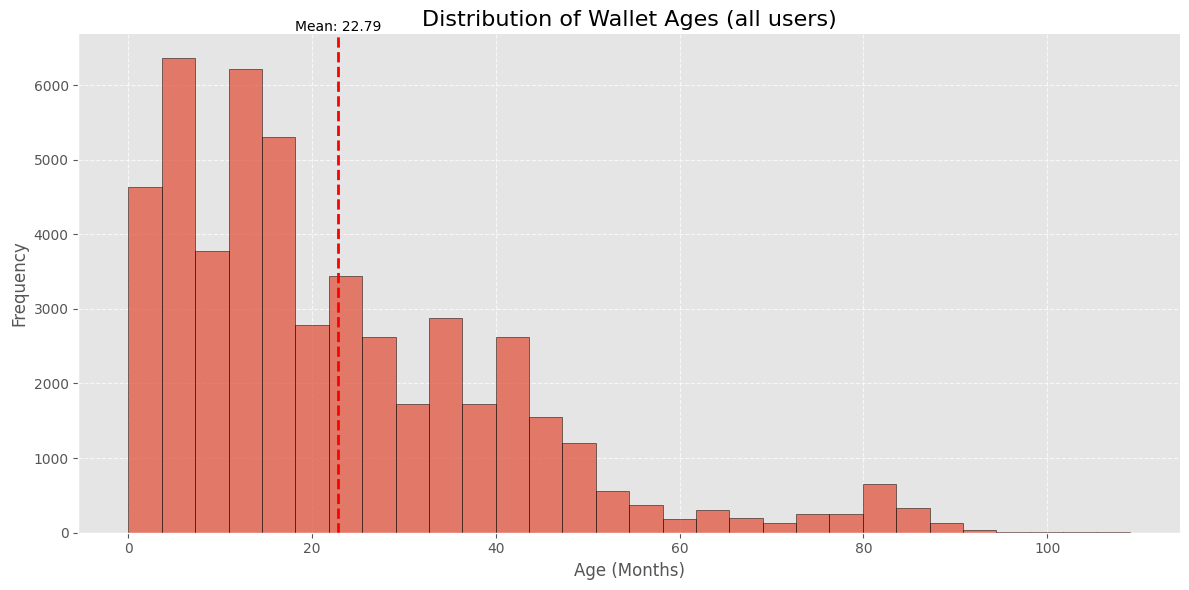

In [66]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np


def calculate_age_months(first_transaction_date):
    current_date = datetime.now()
    first_date = datetime.strptime(first_transaction_date, "%Y-%m-%dT%H:%M:%S.%fZ")
    age_months = (current_date.year - first_date.year) * 12 + (current_date.month - first_date.month)
    return age_months

ages = {}
for user, user_data in all_results:
    if user_data and isinstance(user_data, dict) and 'active_chains' in user_data:
        for chain in user_data['active_chains']:
            if isinstance(chain, dict) and chain.get('chain') == 'eth':
                first_transaction = chain.get('first_transaction')
                if isinstance(first_transaction, dict):
                    first_transaction_date = first_transaction.get('block_timestamp')
                    if first_transaction_date:
                        try:
                            age = calculate_age_months(first_transaction_date)
                            ages[user] = (age)
                        except ValueError:
                            print(f"Invalid date format: {first_transaction_date}")

ages_series = pd.Series(ages)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 6))
ages_series.hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Ages (all users)', fontsize=16)
ax.set_xlabel('Age (Months)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = ages_series.mean()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [67]:
from utils.gho_filter import filter_gho_users
gho_users = set(filter_gho_users(data))
len(gho_users)

2297

In [68]:
gho_ages_series = ages_series[list((gho_users) & set(ages_series.index))]

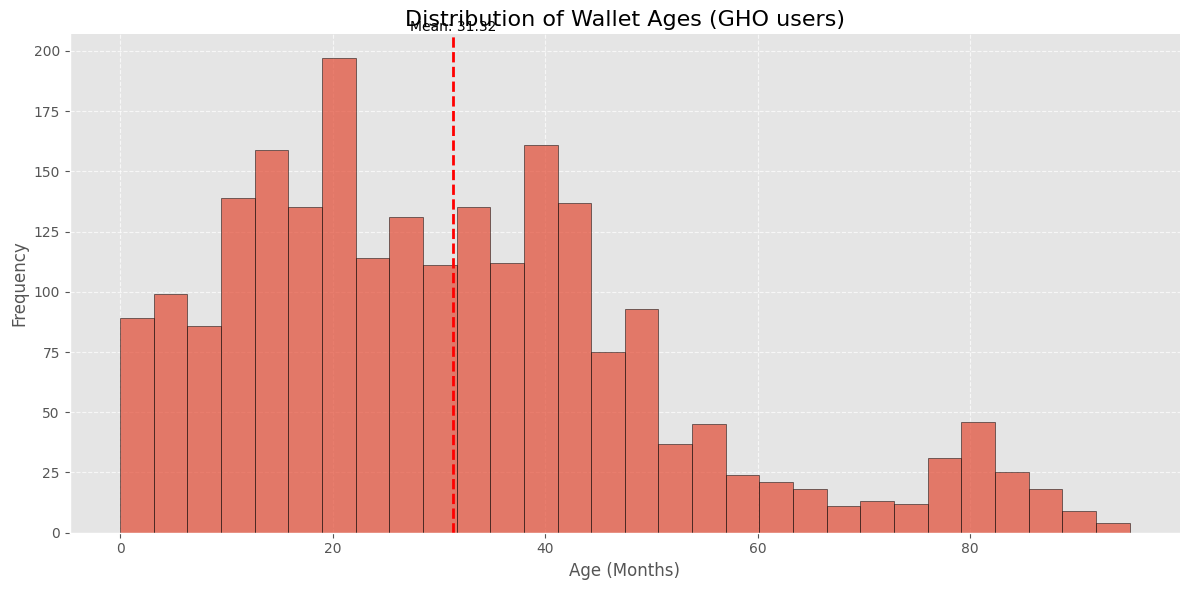

In [69]:

fig, ax = plt.subplots(figsize=(12, 6))
gho_ages_series.hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Ages (GHO users)', fontsize=16)
ax.set_xlabel('Age (Months)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = gho_ages_series.mean()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [70]:
non_gho_ages_series = ages_series[list(set(ages_series.index) -(gho_users))]

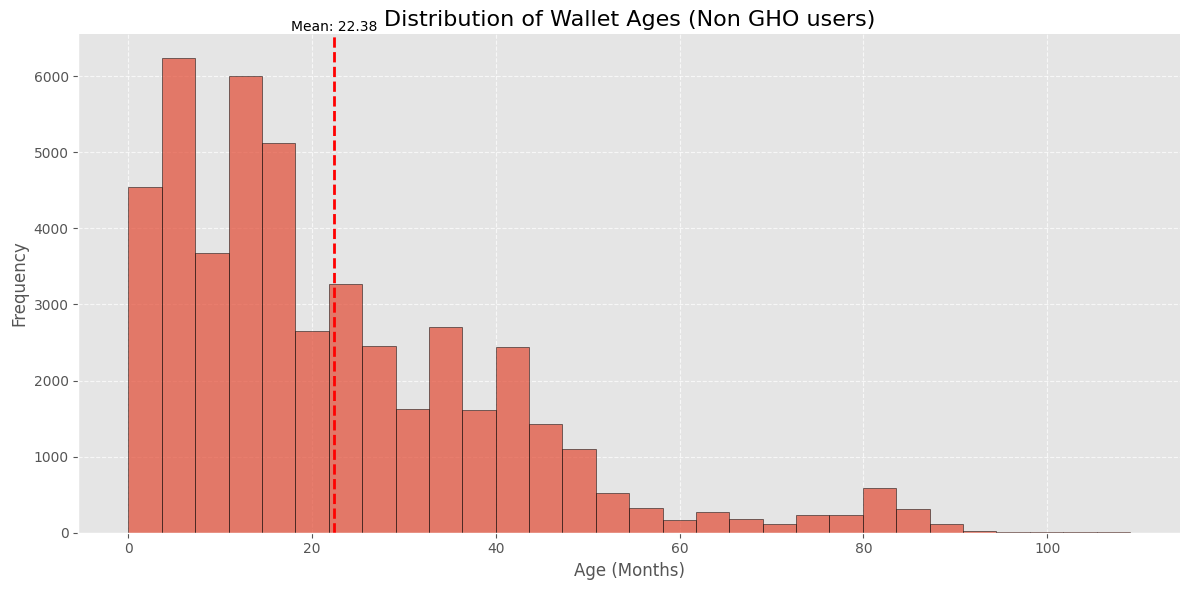

In [71]:

fig, ax = plt.subplots(figsize=(12, 6))
non_gho_ages_series.hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Ages (Non GHO users)', fontsize=16)
ax.set_xlabel('Age (Months)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = non_gho_ages_series.mean()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [81]:
full_age_series = {
    'v3': list(non_gho_ages_series),
    'gho': list(gho_ages_series),
}
with open('wallet_ages_series.json', 'w') as f:
    json.dump(full_age_series, f)

In [80]:
non_gho_ages_series

0xc6ac0bf170dea9fbf8ed4c64fba21ceb15c0daf3    21
0x41538283f0cac4e338db29d96d195d7b8042b186    88
0xbfd28deeba8cac345e0e305995cc3c46af09bccc     5
0xb5251331c6561deb2afa6bc9f040b0dde309cdab    15
0x844dc38bfa4882eec8c5b85dceb08fc66a7a4fbe    37
                                              ..
0x3b03a3567c29a6041f34f17ff4ca32ff818cec5a     3
0x8f30adaa6950b31f675bf8a709bc23f55aa24735    13
0x64a58283497f8bb0fc3be0811e9b4190e6e0f67c    31
0x6dcd8c20a86cbe6560d7a9e0f7802fdae1a1a004    17
0xf6d43cfbcfc9915a59c815811892a0d08606cf2c    20
Length: 47986, dtype: int64

In [60]:
def get_histogram_data(series, bins=30):
    counts, bin_edges = np.histogram(series, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return {
        'bins': bin_centers.tolist(),
        'counts': counts.tolist()
    }

all_users_data = get_histogram_data(ages_series)
gho_users_data = get_histogram_data(gho_ages_series)
non_gho_users_data = get_histogram_data(non_gho_ages_series)

histogram_data = {
    'all_users': all_users_data,
    'non_gho_users': all_users_data,
    'gho_users': gho_users_data
}

with open('wallet_ages_histogram.json', 'w') as f:
    json.dump(histogram_data, f)

In [61]:
raw_data = {
    #'all_users': ages_series.to_list(),
    'gho_users': gho_ages_series.to_list(),
    'non_gho_users': non_gho_ages_series.to_list()
}

with open('wallet_ages_months_by_category.json', 'w') as f:
    json.dump(histogram_data, f)


In [39]:
ages_series.index

Index(['0x00000000000004f93b0c4bbaadff9e5742574b59',
       '0x000000000000bb1b11e5ac8099e92e366b64c133',
       '0x000000000000c9b3e2c3ec88b1b4c0cd853f4321',
       '0x00000000005bbb0ef59571e58418f9a4357b68a0',
       '0x0000000000a0aa7908bda39fbb8f95e5a0a6ee42',
       '0x0000000000a9a823cf72cf7818fb32f38c66dde3',
       '0x00000000032962b51589768828ad878876299e14',
       '0x000000005debd78f9271e9f0363beebdc2fc415b',
       '0x00000000829ee7b0116e17405c125da2f49577e6',
       '0x0000000087bf5615b053dcabf78c93aa4e5b9c76',
       ...
       '0xfff6f54c55c9ece414bda69c361a72eff62acee4',
       '0xfff8cb22789fafb30492cc4264a711c2ed1973ee',
       '0xfff9520630aa6f84464e2095f052a218dfde923f',
       '0xfff95fbe9f34bdeff54de0c7088bb3376a446caf',
       '0xfffa7919dac9bf800188afd9b6b3b655ea857121',
       '0xfffca1c293306f2b3ba5fc35caf338f250d81f91',
       '0xfffcb3903a402b4669e232b53bc6bcebff6eb131',
       '0xfffd6914044ad28937c137c5e73b6ff8468e5970',
       '0xfffe489bce5fa105a2ae6675c

In [48]:
import os
from web3 import Web3
from concurrent.futures import ThreadPoolExecutor
import asyncio
import nest_asyncio
from tqdm import tqdm

WEB3_PROVIDER_URL = os.getenv('WEB3_PROVIDER_URL')
w3 = Web3(Web3.HTTPProvider(WEB3_PROVIDER_URL))

nest_asyncio.apply()

def get_nonce(address):
    return w3.eth.get_transaction_count(Web3.to_checksum_address(address), 'latest')

def batch_get_nonces(addresses):
    return [get_nonce(address) for address in addresses]

def process_addresses(addresses):
    nonces = batch_get_nonces(addresses)
    return dict(zip(addresses, nonces))

batch_size = 100
address_batches = [list(ages_series.index)[i:i + batch_size] for i in range(0, len(ages_series.index), batch_size)]

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_addresses, address_batches), total=len(address_batches)))

nonce_dict = {}
for result in results:
    nonce_dict.update(result)

100%|██████████████████████████████████████████████████████████████████████████████| 503/503 [08:35<00:00,  1.02s/it]


In [49]:
import pickle
with open('wallet-nonces.pickle', 'wb') as fp:
    pickle.dump(nonce_dict, fp)

In [51]:
nonce_df = pd.Series(nonce_dict)
nonce_df

0x00000000000004f93b0c4bbaadff9e5742574b59    34
0x000000000000bb1b11e5ac8099e92e366b64c133     1
0x000000000000c9b3e2c3ec88b1b4c0cd853f4321     1
0x00000000005bbb0ef59571e58418f9a4357b68a0     1
0x0000000000a0aa7908bda39fbb8f95e5a0a6ee42     1
                                              ..
0xfffca1c293306f2b3ba5fc35caf338f250d81f91    49
0xfffcb3903a402b4669e232b53bc6bcebff6eb131    32
0xfffd6914044ad28937c137c5e73b6ff8468e5970    27
0xfffe489bce5fa105a2ae6675c4866242470a3cf0    79
0xffff2f43e105245beabf6a236bdeca118bb3c97e    15
Length: 50273, dtype: int64

In [52]:
gho_nonce_series = nonce_df[list((gho_users) & set(nonce_df.index))]

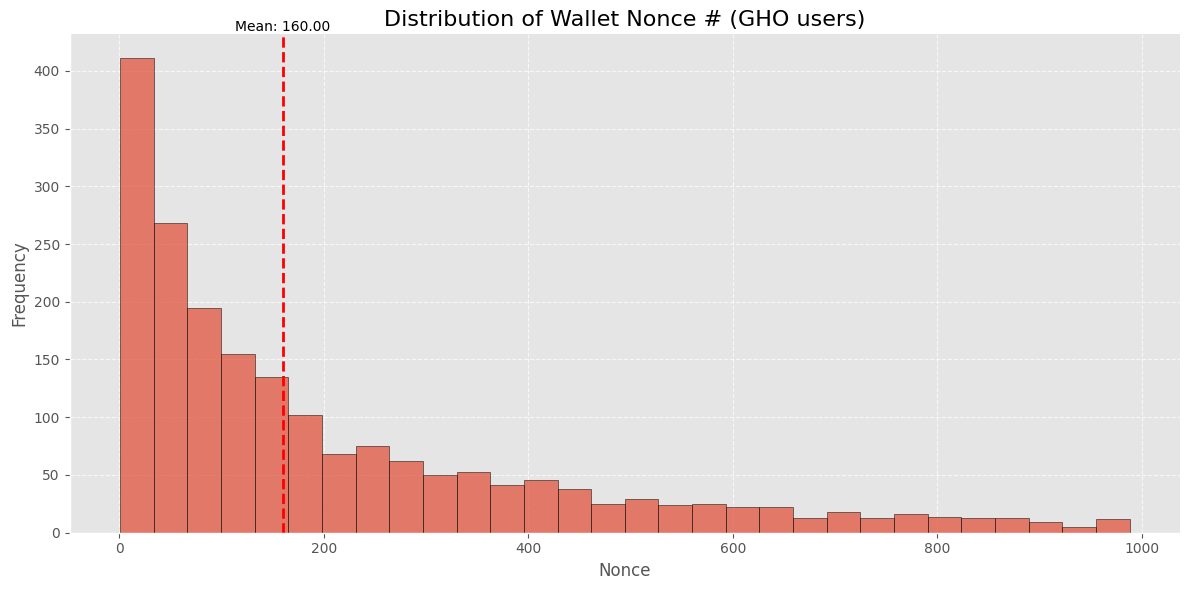

In [56]:

fig, ax = plt.subplots(figsize=(12, 6))
gho_nonce_series[gho_nonce_series < 1e3].hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Nonce # (GHO users)', fontsize=16)
ax.set_xlabel('Nonce', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = gho_nonce_series.median()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [57]:
non_gho_nonce_series = nonce_df[list(set(nonce_df.index) -(gho_users))]

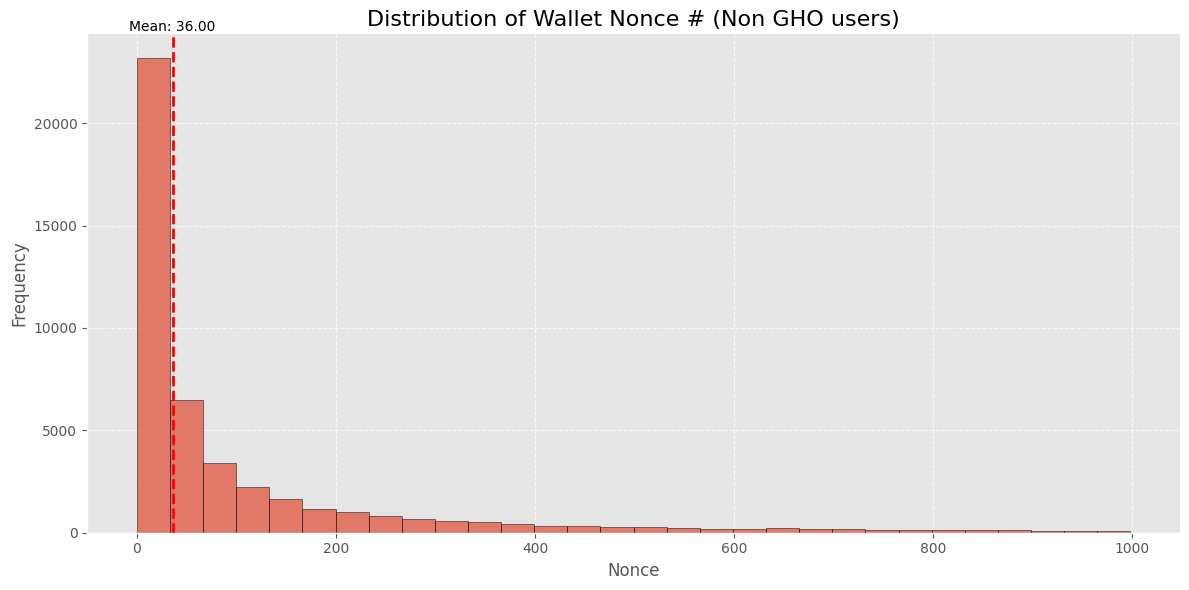

In [59]:

fig, ax = plt.subplots(figsize=(12, 6))
non_gho_nonce_series[non_gho_nonce_series < 1e3].hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Nonce # (Non GHO users)', fontsize=16)
ax.set_xlabel('Nonce', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = non_gho_nonce_series.median()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [82]:
full_nonce_series = {
    'gho': list(gho_nonce_series[gho_nghoonce_series < 1e3]),
    'v3': list(non_gho_nonce_series[non_gho_nonce_series < 1e3]),
}
with open('wallet_nonce_series.json', 'w') as f:
    json.dump(full_nonce_series, f)